In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.COCO_TINY)

In [3]:
images, lbl_bbox = get_annotations(path/'train.json')
img2bbox = dict(zip(images,lbl_bbox))

In [4]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(512),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

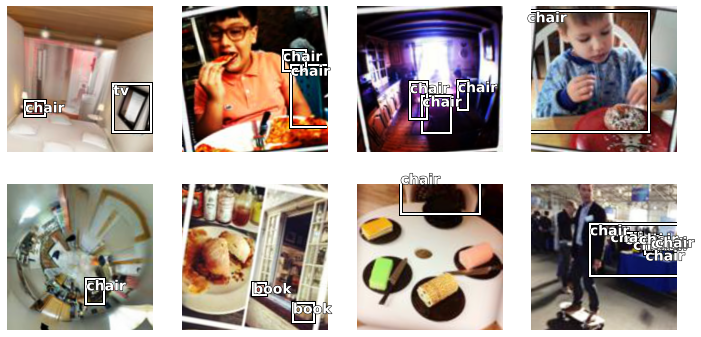

In [5]:
dls = coco.dataloaders(path, bs=8)
dls.show_batch()

In [119]:
lbl_bbox

[([[32.52, 86.34, 41.050000000000004, 95.75],
   [98.12, 110.52, 100.07000000000001, 114.59],
   [91.28, 51.62, 95.23, 57.339999999999996],
   [110.48, 110.82, 125.03, 126.03999999999999],
   [96.63, 50.18, 115.3, 63.64],
   [0.69, 111.73, 12.49, 124.79]],
  ['chair', 'vase', 'vase', 'chair', 'chair', 'chair']),
 ([[118.42, 60.71, 128.0, 77.52],
   [30.3, 71.43, 83.65, 96.9],
   [9.16, 85.58, 67.82, 108.1],
   [102.35, 44.69, 106.94, 50.269999999999996],
   [94.63, 57.16, 99.56, 59.449999999999996],
   [97.58, 60.12, 102.0, 65.83],
   [93.8, 71.0, 102.63, 73.62],
   [64.27, 86.13, 77.44999999999999, 92.39999999999999],
   [74.08, 86.11, 85.3, 90.73],
   [83.35, 89.92, 98.47, 96.53],
   [96.46, 44.46, 99.67999999999999, 50.99],
   [102.87, 54.78, 106.22, 59.07],
   [79.45, 94.51, 86.97, 98.65],
   [69.3, 87.0, 73.89, 89.43],
   [93.8, 43.85, 97.2, 50.92],
   [97.85, 44.77, 102.55999999999999, 50.620000000000005],
   [100.83, 45.08, 104.85, 50.37],
   [93.97, 37.36, 96.88, 42.17],
   [10

In [120]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [121]:

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
from model import *


In [7]:
encoder = create_body(resnet34, pretrained=True)

In [8]:
num_cat=get_c(dls)

In [9]:
arch = RetinaNet(encoder, num_cat, final_bias=-4)

In [10]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=124, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=4, bias=False)
)

In [11]:
arch.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [12]:
arch.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [13]:
arch.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [14]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

In [15]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [16]:
def _retinanet_split(m): 
    return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7,
                                     m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [24]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)#.to_fp16()

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=6.309573450380412e-07)

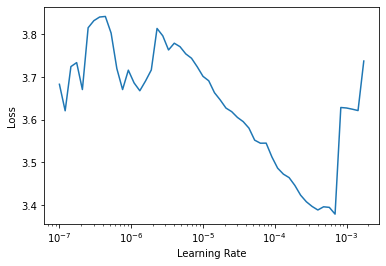

In [25]:
learn.lr_find()

In [26]:
learn.freeze()

In [27]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,3.393943,3.702996,00:13
1,3.223763,3.085188,00:13
2,3.083188,3.728878,00:13
3,3.018605,3.022071,00:13
4,2.933108,2.974352,00:13
5,2.840691,3.077762,00:13
6,2.783075,2.958119,00:13
7,2.726485,3.340634,00:14
8,2.673372,2.988668,00:14
9,2.636907,2.999602,00:14


In [28]:
show_preds()

TypeError: object of type 'int' has no len()

In [29]:
from inference import *

In [30]:
learn.show_preds()

AttributeError: 'Learner' object has no attribute 'show_preds'